In [1]:
# default_exp shopping

In [2]:
import sys
sys.path

['/home/ec2-user/SageMaker/stacks/villaEcommerceBackend/backend/thinClient',
 '/home/ec2-user/SageMaker/.persisted_conda/python38/lib/python38.zip',
 '/home/ec2-user/SageMaker/.persisted_conda/python38/lib/python3.8',
 '/home/ec2-user/SageMaker/.persisted_conda/python38/lib/python3.8/lib-dynload',
 '',
 '/home/ec2-user/SageMaker/.persisted_conda/python38/lib/python3.8/site-packages',
 '/home/ec2-user/SageMaker/.persisted_conda/python38/lib/python3.8/site-packages/IPython/extensions',
 '/home/ec2-user/.ipython']

# Shopping
simulates shopping with python code. 
this is designed to test the backend and allow conversion to frontend

In [76]:
#export
from villaProductSdk.products import ProductSdk
from villaBackendSdk.basket import BasketSdk
from dataclasses_json import dataclass_json 
from dataclasses import dataclass, field
from awsSchema.apigateway import Response, Event
from nicHelper.wrappers import add_class_method, add_method, add_static_method
from typing import List, Optional
from s3bz.s3bz import S3
import json
from requests import post, get
import pandas as pd
import requests
from requests import post
from PIL import Image
from io import BytesIO

## browsing Items

In [4]:
#export
class Basket:
  def __init__(self, basketId = ''):
    self.basketId = basketId
  def setBasketId(self, basketId):
    self.basketId = basketId
class Order:
  def __init__(self, orderId = ''):
    self.orderId = orderId
  def setOrderId (self, orderId):
    self.orderId = orderId
class Browser:
  def __init__(
    self, 
    searchEndpoint = 'https://8av9li9v82.execute-api.ap-southeast-1.amazonaws.com/Prod/orismaSearch/',
    branch = 'dev-manual',
    basketId = '',
    orderId = ''
    ):
    self.searchEndpoint = searchEndpoint
    self.productSdk = ProductSdk(branch = branch)
    self.Basket = Basket
    self.basket = Basket()
    self.Order = Order
    self.order = Order(orderId)
    


In [5]:
browser = Browser()

In [128]:
@add_method(Browser)
def search(self, searchQuery:str)-> List[str]:
  endpoint = self.searchEndpoint
  queries = {
    'data_t3':searchQuery
  }
  response = get(endpoint, params=queries)
  result = response.json()
  try:
    resultList = pd.DataFrame(result)['pr_code'].to_list()
  except:
    print(result)
  return resultList

In [129]:
%%time
resultList = browser.search('rose')
resultList[:10]

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 1.12 s


['0193215',
 '0205723',
 '0177284',
 '0158034',
 '0214013',
 '0176563',
 '0139027',
 '0230898',
 '0175742',
 '0171289']

### Search for items

In [ ]:
@add_method(Browser)
def search(self, searchQuery:str)-> List[str]:
  endpoint = self.searchEndpoint
  queries = {
    'data_t3':searchQuery
  }
  response = get(endpoint, params=queries)
  result = response.json()
  try:
    resultList = pd.DataFrame(result)['pr_code'].to_list()
  except:
    print(result)
  return resultList

In [6]:
#export
@add_method(Browser)
def search(self, searchQuery:str)-> List[str]:
  endpoint = self.searchEndpoint
  queries = {
    'data_t3':searchQuery
  }
  response = get(endpoint, params=queries)
  result = response.json()
  try:
    resultList = pd.DataFrame(result)['pr_code'].to_list()
  except:
    print(result)
    if result == []: print('didnt find any result')
    return result
  return resultList

In [7]:
%%time
resultList = browser.search('pork')
resultList[:10]

CPU times: user 15.7 ms, sys: 3.14 ms, total: 18.9 ms
Wall time: 4.5 s


['0224647',
 '0227251',
 '0220773',
 '0220774',
 '0227293',
 '0226773',
 '0224645',
 '0226772',
 '0224646',
 '0221386']

### get info for searched item

In [8]:
@add_method(Browser)
def getProductInfo(self,products:list)->(List[dict],List[dict]):
#   products = []
#   errors = []
  items=self.productSdk.queryList(products)
#   for result in resultList:
#     if (item := self.productSdk.(result)).get('error'):
#       products.append(item)
#     else:
#       errors.append(result)
  print(f'found {len(items)} products out of {len(products)} products')
  return items

In [9]:
%time products = browser.getProductInfo(resultList)
%time productsDf = pd.DataFrame(products)
print(productsDf.shape)
productsDf.head()

found 555 products out of 781 products
CPU times: user 28.5 ms, sys: 19.3 ms, total: 47.8 ms
Wall time: 3.73 s
CPU times: user 9.87 ms, sys: 0 ns, total: 9.87 ms
Wall time: 9.89 ms
(555, 52)


,cprcode,iprcode,oprcode,ordertype,pr_abb,pr_active,pr_cgcode,pr_code,pr_dpcode,pr_engname,...,pr_brand_th,pr_online_name_en,pr_online_name_th,hema_name_en,hema_name_th,pr_name_en,pr_name_th,pr_barcode,pr_barcode2,sort_weight
0,0060272,0060272,0060272,Y,S-PURE PORK LIVER,Y,08,0060272,27,S-PURE PORK LIVER,...,S-pure,S-Pure Pork Liver,S-PURE ตับหมู,S-Pure Pork Liver,S-PURE ตับหมู,S-PURE PORK LIVER,S-PURE ตับหมู 2 กก/ถุง,2602723,260272,0
1,0031270,0031270,0031270,Y,S.KHON KAEN DRIED PO,Y,80,0031270,21,S.KHON KAEN DRIED PORK 200 G.,...,S. KHON KAEN,S.khon Kaen Dried Pork 220g.,S.KHON KAEN หมูสวรรค์อบ 220 G.,S.khon Kaen Dried Pork 220g.,S.KHON KAEN หมูสวรรค์อบ 220 G.,S.KHON KAEN DRIED PORK 200 G.,S.KHON KAEN หมูสวรรค์อบ 200 G,None,None,0
2,0112059,0112059,0112059,Y,S-PURE PORK COLLAR S,Y,08,0112059,27,S-PURE PORK COLLAR SLICED SHABU,...,S-pure,S-pure Pork Shoulder for Shabu Shabu 1pk,S-PURE PORK SHOULDER SHABUSHABU,S-pure Pork Shoulder for Shabu Shabu 1pk,S-PURE PORK SHOULDER SHABUSHABU,S-PURE PORK SHOULDER SHABUSHABU,S-PURE ไหล่สไลด์ชาบู,2018094,201809,0
3,0026157,0026157,0026157,Y,S.KHON KAEN SHREDDED,Y,80,0026157,21,S.KHON KAEN SHREDDED PORK 100 G.,...,S. KHON KAEN,S Khon Kaen Shredded Pork 100g,S.KHON KAEN หมูหยองกรอบ 100 G.,S Khon Kaen Shredded Pork 100g,S.KHON KAEN หมูหยองกรอบ 100 G.,S.KHON KAEN SHREDDED PORK 100 G.,S.KHON KAEN หมูหยองกรอบ 100 G.,None,None,0
4,0098121,0098121,0098121,Y,HEINZ BAKED BEANZ &,Y,81,0098121,28,HEINZ BAKED BEANZ & PORK SAUSAGES 415G,...,,Heinz Baked Beans & Pork Sausages 415g,Heinz Baked Beans & Pork Sausages 415g,Baked Beans & Pork Sausages,Baked Beans & Pork Sausages,HEINZ BAKED BEANZ & PORK SAUSAGES 415G,HEINZ BAKED BEANZ & PORK SAUSAGES 415G,5000157025272,500015702527,0


## Basket

In [70]:
#export
## general functions
basketRootUrl = 'https://ad3pw0tze2.execute-api.ap-southeast-1.amazonaws.com/Prod'
basketEndpoints = lambda path: f'{basketRootUrl}/{path}'

In [71]:
@add_class_method(Basket)
def generalInvoke(cls, path:str, payload:dict, 
                  successHandler = lambda x: f'function successful {x}',
                  failureHandler = lambda x: f'function failed due to {x}'):
  r:requests.Response = post(url = basketEndpoints(path), json = payload)
  responsePayload = r.json()
  if r.status_code == 200:
    print(successHandler(responsePayload))
  else:
    print(failureHandler(responsePayload))
  return responsePayload

### Create a new basket

In [80]:
#export
@dataclass_json
@dataclass
class Create:
  basketId:str 
  basketName:str 
  ownerId:str
  branchId:str
@add_class_method(Basket)
def createBasket(self, basketId, basketName, ownerId, branchId):
  payload:dict = Create(basketId=basketId, basketName = basketName, ownerId=ownerId, branchId=branchId).to_dict()
  return self.generalInvoke(path='create', payload=payload)


In [81]:
data = {
  'basketId': '0987654321',
  'basketName': 'hello',
  'ownerId': '1234',
  'branchId': '123'
}
browser.basket.createBasket(**data)

function successful {'error': 'bucketExist'}


{'error': 'bucketExist'}

### add/remove products to basket
to remove just put a negative addition

In [72]:
#export
@dataclass_json
@dataclass
class Item:
  sku: str
  quantity: int
@dataclass_json
@dataclass
class Add:
  basketId:str 
  items:List[Item]
    
@add_class_method(Basket)
def addToBasket(self, basketId:str, items:List[Item]):
  payload:dict = Add(basketId=basketId, items=items).to_dict()
  return self.generalInvoke(path='add', payload=payload)


In [73]:
items = [
  {'sku': '12345r', 'quantity': 12},
  {'sku': 'asf', 'quantity': 3}
  
]
browser.basket.addToBasket(basketId='0987654321', items = items)

function successful {'basketId': '0987654321', 'creationTime': 1608824784.046022, 'basketName': 'hello', 'ownerId': '1234', 'productList': [{'sku': '12345r', 'quantity': 24}, {'sku': 'asf', 'quantity': 6}]}


{'basketId': '0987654321',
 'creationTime': 1608824784.046022,
 'basketName': 'hello',
 'ownerId': '1234',
 'productList': [{'sku': '12345r', 'quantity': 24},
  {'sku': 'asf', 'quantity': 6}]}

### update quantity in the basket
ignores the values previously in the basket and set the new values

In [77]:
#export
@dataclass_json
@dataclass
class Update:
  basketId:str 
  ownerId:Optional[str] = field(default_factory=str)
  items:List[Item] = field(default_factory=list)
@add_class_method(Basket)
def update(self, basketId:str, ownerId:str, items:List[Item]):
  payload = Update(basketId=basketId, ownerId=ownerId, items=items).to_dict()
  return self.generalInvoke(path='update', payload=payload)


In [79]:
items = [
  {'sku': '12345r', 'quantity': 12},
  {'sku': 'asf', 'quantity': 3}
]
browser.basket.update(basketId='0987654321', ownerId= '1234', items = items)

function successful {'basketId': '0987654321', 'creationTime': 1608824784.046022, 'basketName': 'hello', 'ownerId': '1234', 'productList': [{'sku': '12345r', 'quantity': 12}, {'sku': 'asf', 'quantity': 3}]}


{'basketId': '0987654321',
 'creationTime': 1608824784.046022,
 'basketName': 'hello',
 'ownerId': '1234',
 'productList': [{'sku': '12345r', 'quantity': 12},
  {'sku': 'asf', 'quantity': 3}]}

In [23]:
@add_method(Order)
def createOrder(self, userId:str, skus:[str]):
  self.orderId = 'randomOrderId'
  print(f'created order {self.orderId}')

In [24]:
browser.order.createOrder(userId='123', skus = ['123', '123'])

created order randomOrderId


In [21]:
@add_method(Order)
def checkOut(self, skus:[str]):
  print(f'add {skus} to order {self.orderId}')
  

In [22]:
browser.order.checkOut(['0000009', '9999913'])

add ['0000009', '9999913'] to order


## Get images

In [36]:
def showImage(im: Image):
  width, height = im.size
  return im.resize((int(100* width/height),100))

In [37]:
@add_method(Browser)
def getLargeImage(self, sku:str)->Image:
  url = 'http://d19oj5aeuefgv.cloudfront.net'
  imageContent = requests.get(f'{url}/{sku}').content
  return Image.open(BytesIO(imageContent),formats=['PNG'])

CPU times: user 7.24 ms, sys: 0 ns, total: 7.24 ms
Wall time: 33 ms
image is size (720, 922)


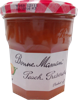

In [38]:
sku = '0189194'
%time largeImage:Image = browser.getLargeImage(sku)
print(f'image is size {largeImage.size}')
showImage(largeImage)


In [27]:
@add_method(Browser)
def getSmallImage(self, sku:str)->Image:
  url = 'https://d1vl5j0v241n75.cloudfront.net'
  imageContent = requests.get(f'{url}/{sku}').content
  return Image.open(BytesIO(imageContent),formats=['PNG'])

CPU times: user 13.7 ms, sys: 0 ns, total: 13.7 ms
Wall time: 32.9 ms


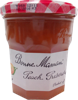

In [39]:
%time smallImage = browser.getSmallImage(sku)
showImage(smallImage)